# Node elevations and edge grades

OSMnx, yükseklik veri kaynağı olarak yerel tarama dosyalarını veya Google Haritalar Yükseklik API'sini kullanarak, yükseklik modülüyle grafiğinizin düğümlerine otomatik olarak yükseklik nitelikleri eklemenize olanak tanır. Google API kullanıyorsanız, bir API anahtarına ihtiyacınız olacaktır. Düğümleriniz yükseklik değerlerine sahip olduğunda, OSMnx kenarlarınızın derecelerini (eğimlerini) otomatik olarak hesaplayabilir.

In [1]:
import sys

import numpy as np
import osmnx as ox
import pandas as pd

%matplotlib inline
ox.__version__

'1.3.0'

# Elevation from local raster file(s)

OSMnx, tek bir raster dosyası veya bir raster dosyaları listesi kullanarak grafik düğümlerine yükseklikler ekleyebilir. İkincisi, bu dosya yollarındaki rasterlerden oluşan bir sanal raster VRT oluşturur. Varsayılan olarak, mevcut tüm CPU'ları kullanır, ancak bunu bir bağımsız değişkenle yapılandırabilirsiniz.

In [2]:
address = "600 Montgomery St, San Francisco, California, USA"
G = ox.graph_from_address(address=address, dist=500, dist_type="bbox", network_type="bike")

In [3]:
# add node elevations from a single raster file
# some nodes will be null because the single file does not cover the graph's extents
raster_path = "./input_data/elevation1.tif"
G = ox.elevation.add_node_elevations_raster(G, raster_path, cpus=1)

ImportError: gdal and rasterio must be installed to query raster files

In [4]:
# add node elevations from multiple raster files
# no nulls should remain
raster_paths = ["./input_data/elevation1.tif", "./input_data/elevation2.tif"]
G = ox.elevation.add_node_elevations_raster(G, raster_paths)
assert not np.isnan(np.array(G.nodes(data="elevation"))[:, 1]).any()

ImportError: gdal and rasterio must be installed to query raster files

In [5]:
# add edge grades and their absolute values
G = ox.elevation.add_edge_grades(G, add_absolute=True)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

# Elevation from Google Maps Elevation API

In [7]:
# replace this with your own API key!
try:
    from keys import google_elevation_api_key
except ImportError:
    sys.exit()  # you need an API key to proceed

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [9]:
# get the street network for san francisco
place = "San Francisco"
place_query = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place_query, network_type="drive")

In [10]:
# add elevation to each of the nodes, using the google elevation API, then calculate edge grades
G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
G = ox.elevation.add_edge_grades(G)

NameError: name 'google_elevation_api_key' is not defined

# Calculate some summary stats

In [11]:
# calculate the edges' absolute grades (and drop any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.get_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

KeyError: 'grade_abs'

In [ ]:
avg_grade = np.mean(grades)
print("Average street grade in {} is {:.1f}%".format(place, avg_grade * 100))

med_grade = np.median(grades)
print("Median street grade in {} is {:.1f}%".format(place, med_grade * 100))

# Plot the nodes by elevation

In [12]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=5, edge_color="#333333", bgcolor="k")

ValueError: There are no attribute values.

# Plot the edges by grade

In [14]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

ValueError: There are no attribute values.

# Calculate shortest paths, considering grade impedance

In [16]:
# select an origin and destination node and a bounding box around them
origin = ox.distance.nearest_nodes(G, -122.426, 37.77)
destination = ox.distance.nearest_nodes(G, -122.441, 37.773)
bbox = ox.utils_geo.bbox_from_point((37.772, -122.434), dist=1500)

In [17]:
# define some edge impedance function here
def impedance(length, grade):
    penalty = grade**2
    return length * penalty


# add impedance and elevation rise values to each edge in the projected graph
# use absolute value of grade in impedance function if you want to avoid uphill and downhill
for _, _, _, data in G.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade_abs"])
    data["rise"] = data["length"] * data["grade"]

KeyError: 'grade_abs'

First find the shortest path that minimizes trip distance:

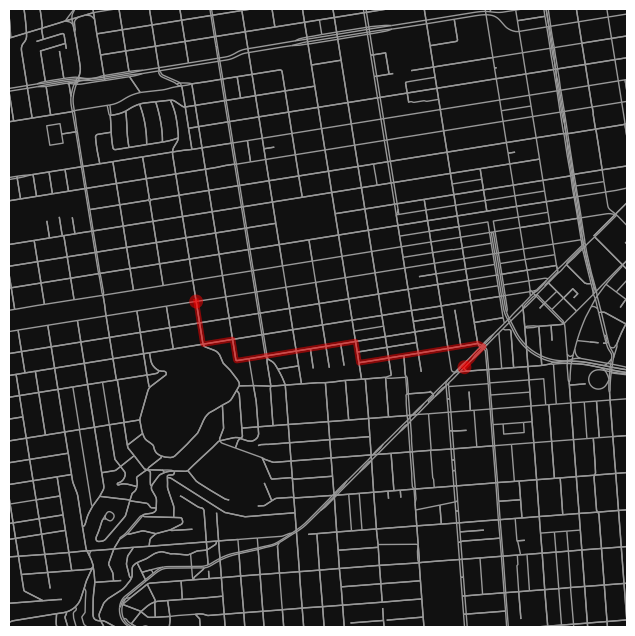

In [18]:
route_by_length = ox.shortest_path(G, origin, destination, weight="length")
fig, ax = ox.plot_graph_route(G, route_by_length, bbox=bbox, node_size=0)

Now find the shortest path that avoids slopes by minimizing impedance (function of length and grade):

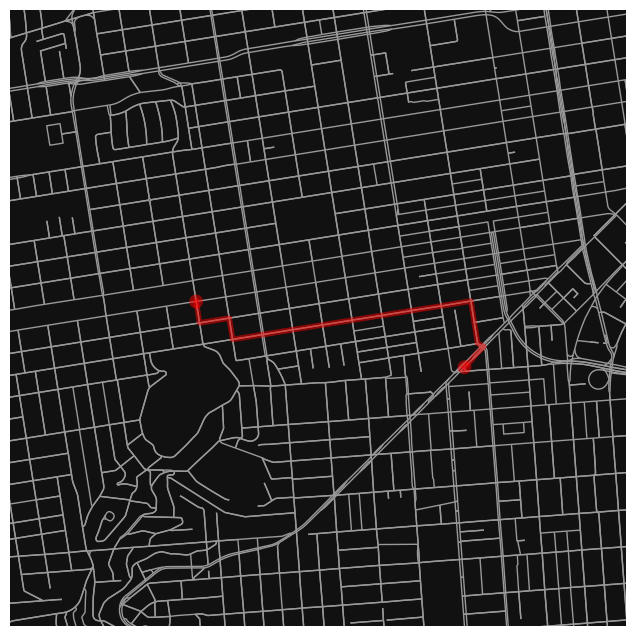

In [19]:
route_by_impedance = ox.shortest_path(G, origin, destination, weight="impedance")
fig, ax = ox.plot_graph_route(G, route_by_impedance, bbox=bbox, node_size=0)

Print some summary stats about these two routes:

In [20]:
def print_route_stats(route):
    route_grades = ox.utils_graph.get_route_edge_attributes(G, route, "grade_abs")
    msg = "The average grade is {:.1f}% and the max is {:.1f}%"
    print(msg.format(np.mean(route_grades) * 100, np.max(route_grades) * 100))

    route_rises = ox.utils_graph.get_route_edge_attributes(G, route, "rise")
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = "Total elevation change is {:.1f} meters: {:.0f} meter ascent and {:.0f} meter descent"
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
    print("Total trip distance: {:,.0f} meters".format(np.sum(route_lengths)))

In [21]:
# stats of route minimizing length
print_route_stats(route_by_length)

KeyError: 'grade_abs'

In [22]:
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

KeyError: 'grade_abs'